# Decompounding Population Spike Counts

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import Correlated_Poisson_Process as pp
import utils as utils

### A new function to generate population spike trains via pre-defined amplitude (book chapter).

In [2]:
def generate_popuActivity(amplitudes_dist, carrier_rate, T):
    '''

    A new function to generate population spike trains via pre-defined amplitude , 
    distribution rate of carrier and observation period 
    '''
    nn = len(amplitudes_dist) # number of neurons
    correlatedST = [np.array([])] * nn  # initialze spike trains
    carrier = pp.generate_parallelST([carrier_rate], T)[0] #realize carrier process
    for idx, spike in enumerate(carrier):
        amplitude_drawn= np.random.choice(np.arange(nn), 1,   # For each spike in carrier, draw a number of amplitudes
                            p = amplitudes_dist) +1           # according to probability distribution. 
        neuron_ids = np.random.choice(np.arange(nn), amplitude_drawn, replace=False) # Assign the spike uniformly to
        for nid in neuron_ids:                                # that number (amplitude_drawn) of neuron.                       
            correlatedST[nid]= np.append(correlatedST[nid],spike)                           
    return correlatedST

### A function to find index in rate list, where amplitude equals specific value.
It is used in order to create specific amplitude distribution through input component rates.

In [3]:
# find index of specific amlitude in the rate list 
def index_of_amplitude(nn, amplitude):
    def to_binary(number,n):
        return ('{0:0'+str(n)+'b}').format(number)
    
    ampl = []
    
    for i in range(1, 2**nn):
        
        binary = to_binary(i,nn)
        ampl.append(binary.count("1"))
    
    ampl = np.array(ampl)
    
    return np.where(ampl==amplitude)


### A function to count number of ones in binary code.

In [4]:

# Convert an integer into binary code and count how many ones are there.
# Input parameter is a list of integers.
def count_ones(n):
    ones = np.zeros(len(n), dtype = int)
    for i in range(len(n)):
        ones[i] = bin(n[i]).count("1")  
    return ones

### 0. Configure  parameters

In [5]:

T = 100       # observation duration
sample_size =100     # smaple size of theta
thetas = np.arange(- np.pi, np.pi, step = 2 * np.pi / sample_size)
nn = 10       # analytical number of neurons
L = 10000       # nubmer of bin
h = T/L       # bin size
n_v = 10      # number of amplitudes to be estimated.


### 1.  Generate poplulation spike trains methode 2: via component rates


In [6]:

# generate poplulation spike trains methode 2: via component rates
index_ampl1 = index_of_amplitude(nn, 1)
index_ampl9 = index_of_amplitude(nn, 9)
rate = np.zeros(2 ** nn -1)
rate[index_ampl1]= 0.9 
rate[index_ampl9]= 1.4

rate_of_amplitudes = np.zeros(nn)
rate_of_amplitudes[0] = 0.9 * np.size(index_ampl1) * h
rate_of_amplitudes[8] = 1.4 * np.size(index_ampl9) * h
print('Expected rate of amplitudes: ', rate_of_amplitudes)


marked_process2 = pp.generate_markedProcess(rate, T)
correlatedST2 = pp.markedProcess_to_correlatedST(marked_process2)  

# caculate counts via marked prococess
nr_ones = count_ones(marked_process2[1])
counts, bin_edges= np.histogram(marked_process2[0], bins = L, range =(0, T), weights = nr_ones, density= False)




Expected rate of amplitudes:  [0.09 0.   0.   0.   0.   0.   0.   0.   0.14 0.  ]


### 1.  Alternative:  generate population spike trains methode 1: via amplitude distribution

In [7]:
# genearte population spike trains methode 1: via amplitude distribution
amplitudes_dist = [0.6, 0, 0, 0, 0, 0, 0, 0, 0.4, 0]
correlatedST = generate_popuActivity(amplitudes_dist, 30, T)
#rate_of_amplitudes = np.array(amplitudes_dist) * h
# caculate counts per spike trains 
counts= [np.array([])]*nn
bin_edges2= [np.array([])]*nn
for i in range(nn):
    count, bin_edge= np.histogram(correlatedST[i], bins = L, range =(0, T), density= False)
    counts[i]=count
    bin_edges2[i] = bin_edge   
counts = np.sum(counts,axis = 0)

In [8]:
# plot amplitude distribution of emprical data
# 
# int_mark = marked_process2[1]
# binary_mark = utils.to_binary_matrix(int_mark)
# amplitudes = np.sum(binary_mark, axis = 0)
# count_ampl, bins_ampl, patches_ampl = plt.hist(amplitudes,L, density=False, stacked=True, align='mid', alpha = 0.8)''

### 2. Generate emprical y values and  x in the log amplitude characterisc function.

In [9]:
#caculate emprical y values
y_emprical = []
sum1 = np.zeros(sample_size)
for k in range(L):  # L corresponds to n in the formula
    for l in range(L):
        if k < l:
            sum1 = np.cos((counts[k]- counts[l]) *thetas) + sum1
y_emprical =  - np.log(L) + 1/2 * np.log(L + 2 *sum1)

  
    
# analytical x
x = np.zeros((sample_size, n_v))
for i in range(sample_size):
    for k in range(n_v):
        x[i,k] = np.cos((k+1) * thetas[i]) - 1

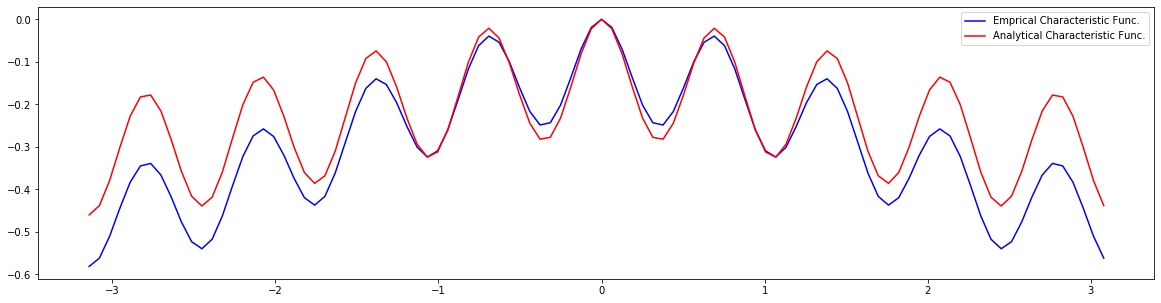

In [10]:
# plot the two functions
log_amplitude = np.dot(x, rate_of_amplitudes)
plt.figure(figsize = (20,5) )
plt.plot(thetas, y_emprical, color = 'blue',label = 'Emprical Characteristic Func.')  
plt.plot(thetas,log_amplitude,color = 'red', label = 'Analytical Characteristic Func.')   
plt.legend()

### 3. Use Moore-Penrose-Inverse to caculate the coefficients of multiple linear regression.

In [11]:
# pseudo inverse 
lambda_est = np.dot(np.linalg.pinv(np.dot(x.T,x)),np.dot(x.T,y_emprical)) # lambda_est = (X^T X)^(-1) X^T y
print(lambda_est)

[ 1.71394889e-01 -1.74595078e-03  2.44407254e-04  6.25749152e-05
 -3.12179279e-05 -1.29159790e-05 -1.47400025e-05 -1.45884048e-05
  1.17687475e-01  2.12144088e-03]


### 3. Alternative: fitting with constraints

In [12]:
# non linear fitting with constraints, scipy.optimize.lsq_linear
from scipy.optimize import lsq_linear
b1 = np.zeros(nn)
b2 = [np.sum(nr_ones)/L] *nn
#b2 = [np.inf]*nn
res= lsq_linear(x, y_emprical, bounds=(b1, b2), lsmr_tol='auto', verbose=1)
res['x']


The first-order optimality measure is less than `tol`.
Number of iterations 16, initial cost 3.3948e+01, final cost 1.4620e-04, first-order optimality 3.66e-12.


array([1.70962766e-01, 2.53887937e-17, 3.89492889e-10, 2.16803335e-12,
       5.11612756e-13, 6.57997676e-13, 6.41351917e-13, 6.42716123e-13,
       1.17255351e-01, 1.68931764e-03])

### 3. Alternative: Use the fomula in the paper to caculate rates.
Results are different from using linear regression.

In [13]:
# EDP - analytical estimated rates, using the foluma in the paper, same as obove section.
import scipy.integrate as integrate
gamma_est = []
v = np.zeros(n_v)
z_l =[0] * L + 1j * counts
for tt in thetas:
    gamma_est.append(1/L * np.sum(np.e ** (z_l * tt)))
    
n_l =[0] *n_v - 1j * (np.arange(n_v)+1)    

def func(t, k): # t is theta
    return np.log( 1/ L * np.sum (np.e ** (z_l * t)) ) * np.e**(n_l[k] * t)

for k in range(n_v):
    integral = integrate.quad(func, -np.pi, np.pi, args = (k))
    v[k] = 1 / (2 * np.pi) * (1 / h) * integral[0]

print(v)


C:\Users\Willkommen\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


[ 1.71409486e+01 -1.73135405e-01  2.59003980e-02  7.71716584e-03
 -1.66211983e-03  1.68076197e-04 -1.43264741e-05  8.32341886e-07
  1.17702071e+01  2.13603761e-01]


###  4. Plot analytical, emprical and caculated amplitude distributions.

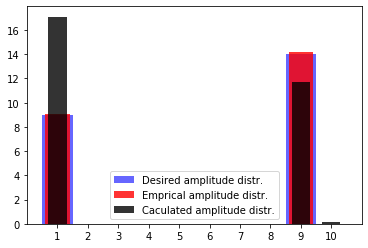

In [14]:
# plot amplitude distribution of emprical data, analytical designed and final result
int_mark = marked_process2[1]
binary_mark = utils.to_binary_matrix(int_mark)
amplitudes = np.sum(binary_mark, axis = 0)
ampl, occurence = np.unique(amplitudes, return_counts=True)
empirical_rates = occurence/T

plt.figure()
index = np.arange(1, len(rate_of_amplitudes)+1)
 
plt.bar(index, rate_of_amplitudes/h, width=1, align='center', alpha = 0.6, color = 'blue', label= 'Desired amplitude distr.')
plt.bar(ampl, empirical_rates, width=0.8, align='center', alpha = 0.8, color = 'red', label = 'Emprical amplitude distr.')
plt.bar(index, res['x']/h, width=0.6, align='center', alpha = 0.8, color = 'black', label= 'Caculated amplitude distr.')
plt.xticks(index)
plt.legend()

In [15]:
# a script, to check the number of amplitudes for given number of neurons, if the population 
# activity is genereated via component rates. 

from itertools import combinations
number_of_neurons = 10
a = np.arange(number_of_neurons)
for i in range(1,number_of_neurons + 1):
    list1 = list(combinations(a,i))
    # print('Amplitude of ',np.shape(list1)[1],  ', Number:', len(list1), '\n')

